# Loading, Inspecting Google Analytics Timeseries data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from time import sleep
import csv

import pandas as pd
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as pyplot

DATA_DIR = "/content/drive/MyDrive/APRD 6342- Digital Marketing/Time Series Analysis Project"


In [ ]:
#source: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#we look through the docs for read_csv and find the "skip row" parameter
googletrends = pd.read_csv('%s/adidas.googletrend.csv' % DATA_DIR, skiprows=[0, 1], parse_dates=['Week'])

In [ ]:
# # Kevin's data loading
googletrends = pd.read_csv('/content/adidas.googletrend (1).csv', skiprows = [0,1], parse_dates=["Week"])

In [ ]:
googletrends.index = googletrends['Week']
del googletrends['Week']

In [ ]:
#1. always to set the index as the date column
googletrends.tail()

,adidas: (United States)
Week,
2018-09-02,57
2018-09-09,52
2018-09-16,61
2018-09-23,56
2018-09-30,50


In [ ]:
#let's get a sense of what the variation in the data is.
#standard deviation is 5.83. Varies from 70 to 100.
print(googletrends['adidas: (United States)'].describe())

count    260.000000
mean      45.038462
std       18.830028
min       17.000000
25%       27.000000
50%       50.000000
75%       58.250000
max      100.000000
Name: adidas: (United States), dtype: float64


<Axes: xlabel='Week'>

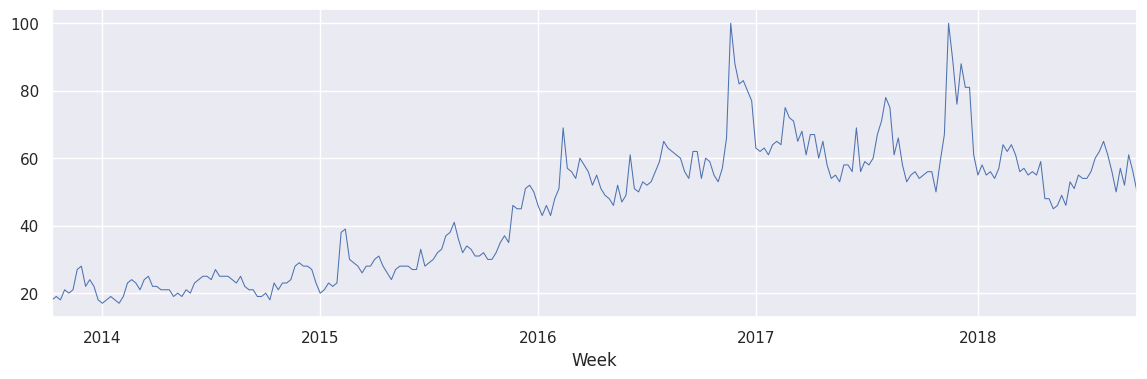

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
googletrends['adidas: (United States)'].plot(linewidth=0.75)

# Learning more about the time series (ADF/ACF/PACF)

Now that we have the data parsed, we're going to work towards modeling this data using a common method in statistics: ARIMA. But to do that, we need to learn about the data a little bit first.

First, we need to learn if the data is stationary. If it's not, we need to incorporate some type of integration component in our model. Put another way, if the data has a mean that changes across time, we're going to need to do something about that later in our ARIMA.

In [ ]:
adf_test(googletrends['adidas: (United States)'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.305135
p-value                          0.626820
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


The p here is > .05. The null hypothesis for both tests is that the data are non-stationary. We can difference the data set. and take a look at what differencing is.

In [ ]:
googletrends['trends_diff_1'] = googletrends['adidas: (United States)'].diff(1)

In [ ]:
googletrends

,adidas: (United States),trends_diff_1
Week,,
2013-10-13,18,NaN
2013-10-20,19,1.0
2013-10-27,18,-1.0
2013-11-03,21,3.0
2013-11-10,20,-1.0
...,...,...
2018-09-02,57,7.0
2018-09-09,52,-5.0
2018-09-16,61,9.0


A difference is just the change from one time measurement to another. The change from 18 to 19 == 1. The change from 19 to 18 == -1, and so on. First order differencing is just taking the last measurement, but you can difference multiple time periods at once. Typically, 2nd, 3rd and 4th order differencing are only done if first order differencing doesn't make the data stationary.

<Axes: xlabel='Week'>

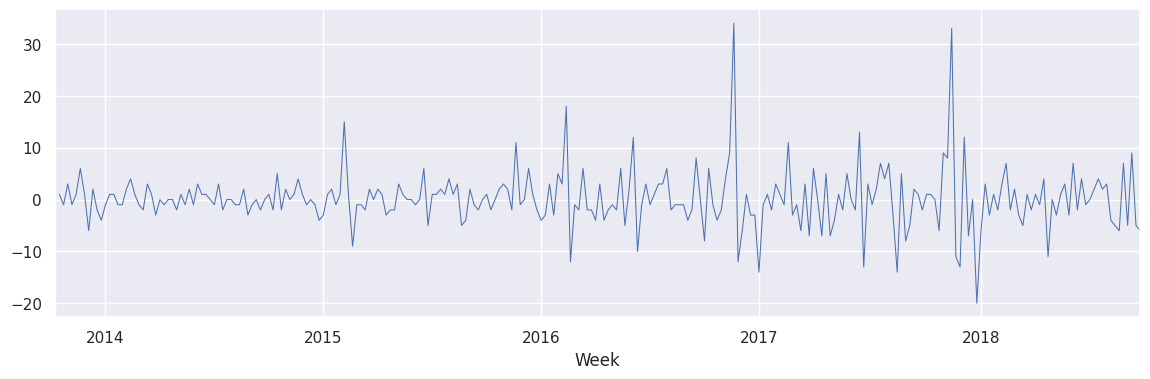

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
googletrends['trends_diff_1'].plot(linewidth=0.75)

There is no moving average, or general trend, here now

In [ ]:
adf_test(googletrends['trends_diff_1'][1:])

Results of Dickey-Fuller Test:
Test Statistic                -7.433755e+00
p-value                        6.261453e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


Our p value is really low, meaning we're stationary now

Check ACF/PACF now





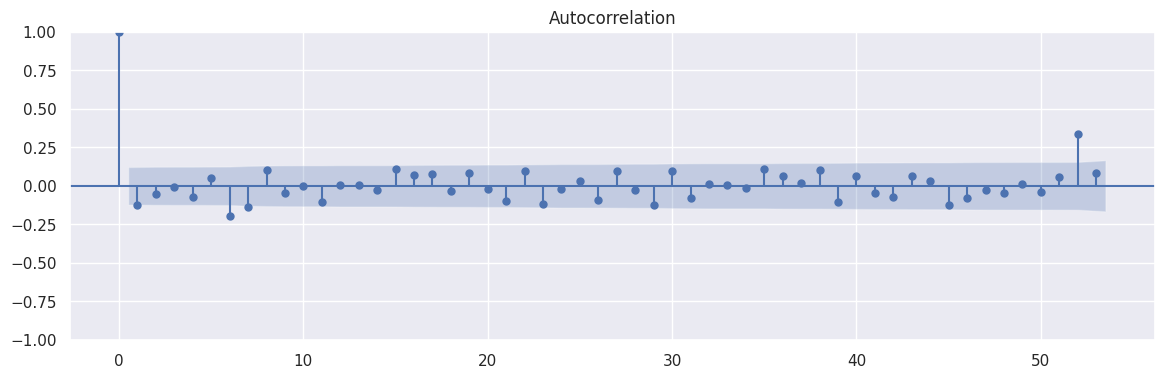

In [ ]:
plot_acf(googletrends['trends_diff_1'][1:], lags=53);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  


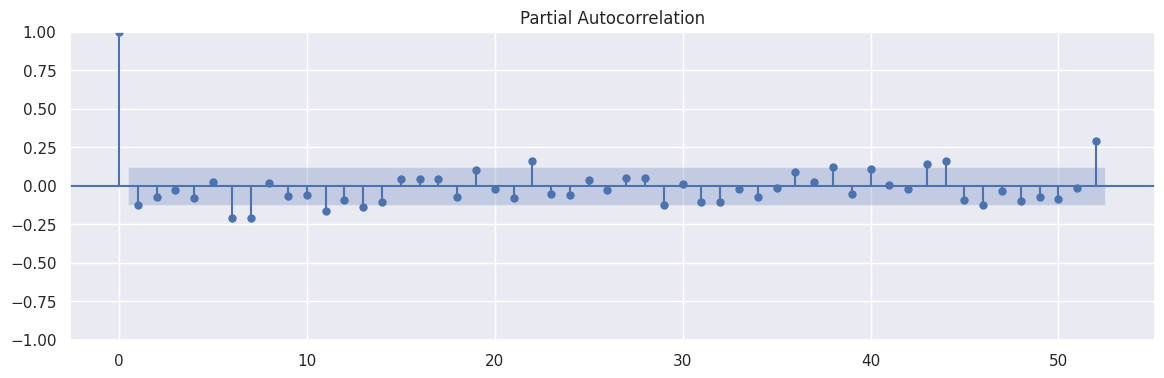

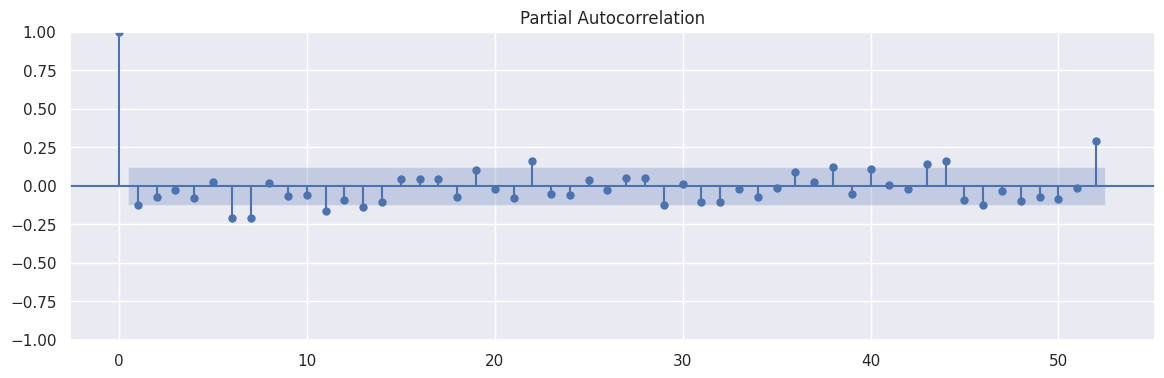

In [ ]:
plot_pacf(googletrends['trends_diff_1'][1:], lags=52)

AS the result shown above, we can first start with order = (5,1,5) and check if there is any other optimal parameter by iteration.

# ARIMA Modeling


In [ ]:
import statsmodels

In [ ]:
# !pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt

Taking the parameters we learned from ADF, ACF and PACF, let's try a model.

AR(5) I(1) MA(5)


In [ ]:
model = ARIMA(googletrends['adidas: (United States)'], order=(5,1,5))
model_fit = model.fit()
summary = model_fit.summary().as_text()
for aline in summary.split(','):
  print(aline)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                  
Dep. Variable:     adidas: (United States)   No. Observations:                  260
Model:                      ARIMA(5
 1
 5)   Log Likelihood                -797.691
Date:                     Fri
 05 May 2023   AIC                           1617.382
Time:                             17:22:17   BIC                           1656.507
Sample:                         10-13-2013   HQIC                          1633.113
                              - 09-30-2018                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6002      0.116     -5.161      0.000      -0.828      -0.372
ar.L2         -0.4530      0.155     -2.919      0.004      -0.757      -0.149
ar.L3       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now try (3,1,3)

In [ ]:
model = ARIMA(googletrends['adidas: (United States)'], order=(3,1,3))
model_fit = model.fit()
summary = model_fit.summary().as_text()
for aline in summary.split(','):
  print(aline)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                  
Dep. Variable:     adidas: (United States)   No. Observations:                  260
Model:                      ARIMA(3
 1
 3)   Log Likelihood                -806.993
Date:                     Fri
 05 May 2023   AIC                           1627.986
Time:                             17:26:38   BIC                           1652.883
Sample:                         10-13-2013   HQIC                          1637.996
                              - 09-30-2018                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5802      0.144     -4.024      0.000      -0.863      -0.298
ar.L2          0.6565      0.184      3.574      0.000       0.296       1.016
ar.L3       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Try another order (3,1,4)

In [ ]:
model = ARIMA(googletrends['adidas: (United States)'], order=(3,1,4))
model_fit = model.fit()
summary = model_fit.summary().as_text()
for aline in summary.split(','):
  print(aline)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     adidas: (United States)   No. Observations:                  260
Model:                      ARIMA(3
 1
 4)   Log Likelihood                -795.866
Date:                     Fri
 05 May 2023   AIC                           1607.732
Time:                             17:26:48   BIC                           1636.187
Sample:                         10-13-2013   HQIC                          1619.173
                              - 09-30-2018                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5647      0.090     -6.254      0.000      -0.742      -0.388
ar.L2          0.0183      0.112      0.163      0.870      -0.202       0.238
ar.L3       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


One final check I consistently see is a Durbin Watson test. We're looking for a value closer to 2 than 1.

A Durbin Watson ranges 0-4. We're looking for a value close to 2. This suggests no autocorrelations amongst residuals, e.g., that we've modeled just about all we can out of the data with lags. That's the case here!

In [ ]:
type(model_fit)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [ ]:
model_fit.resid.head()

Week
2013-10-13    18.000000
2013-10-20     1.000073
2013-10-27    -0.868110
2013-11-03     2.927075
2013-11-10    -0.564368
dtype: float64

<ipython-input-26-7cea896a7046>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, hist=True, kde=True)


<Axes: ylabel='Density'>

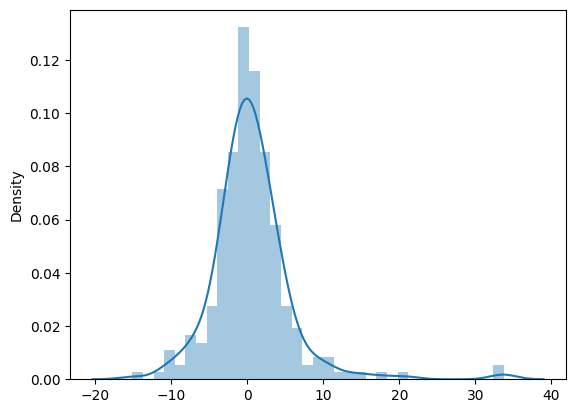

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)


In [ ]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(residuals))

[1.91811402]


The model is a normal distribution. This suggests the model isn't biased in particular ways, e.g., that it consistently under or over predicts. We want the error to be normal, not biased.

Next, let's calculate a quick and dirty average residual error. 

In [ ]:
#absolute value because we're not descriminating from being over or under on a prediction.
absresiduals = abs(residuals)
print(np.mean(abs(residuals)))

0    3.364765
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
#let's get a sense of what the variation in the data is.
#standard deviation is 5.8.
#we can predict within a half of a standard deviation, good. Better than Facebook prophet.
print(googletrends['adidas: (United States)'].describe())

count    260.000000
mean      45.038462
std       18.830028
min       17.000000
25%       27.000000
50%       50.000000
75%       58.250000
max      100.000000
Name: adidas: (United States), dtype: float64


Finally, let's see how this thing actually does when we ask it to recreate the timeseries with only the first value.

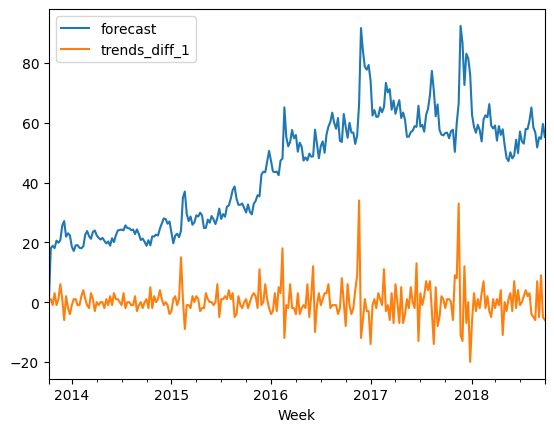

In [ ]:
pd.plotting.register_matplotlib_converters()    
ax = model_fit.predict().plot(label="forecast")
googletrends['trends_diff_1'].plot(ax=ax)
ax.legend()


In [ ]:
model_fit.aic

1607.7322178833635

Now we can use seasonality with SARIMAX to see what would happen

# SARIMA Modeling


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

Taking the parameters we learned from ADF, ACF and PACF, let's try a model. Note that SARIMA allows data with general trends, so we don't need to make the data stationary, but instead feed a trend parameter. we're trying to beat an AIC of ~1636

In [ ]:
# Run SARIMAX without seasonality
model = sm.tsa.statespace.SARIMAX(googletrends['adidas: (United States)'], order=(2,1,3))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     adidas: (United States)   No. Observations:                  260
Model:                    SARIMAX(2, 1, 3)   Log Likelihood                -797.372
Date:                     Fri, 05 May 2023   AIC                           1606.744
Time:                             17:28:09   BIC                           1628.085
Sample:                         10-13-2013   HQIC                          1615.325
                              - 09-30-2018                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8522      0.023     80.989      0.000       1.807       1.897
ar.L2         -0.9738      0.024    -41.336      0.000      -1.020      -0.928
ma.L1       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# With Seasonality set to be 7 weeks.
model = sm.tsa.statespace.SARIMAX(googletrends['adidas: (United States)'], order=(2,1,3), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:             adidas: (United States)   No. Observations:                  260
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood                -794.581
Date:                             Fri, 05 May 2023   AIC                           1605.162
Time:                                     17:29:21   BIC                           1633.398
Sample:                                 10-13-2013   HQIC                          1616.524
                                      - 09-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0695      0.354     -0.196      0.844      -0.763       0.624
ar.L2          0.5909      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# With Seasonality set to be 52 weeks.
model = sm.tsa.statespace.SARIMAX(googletrends['adidas: (United States)'], trend='t', order=(3,1,3), seasonal_order=(1,1,1,52))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:              adidas: (United States)   No. Observations:                  260
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 52)   Log Likelihood                -638.925
Date:                              Fri, 05 May 2023   AIC                           1297.851
Time:                                      17:36:08   BIC                           1331.178
Sample:                                  10-13-2013   HQIC                          1311.328
                                       - 09-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -2.079e-05      0.000     -0.183      0.855      -0.000       0.000
ar.L1          0.33

<ipython-input-47-7cea896a7046>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, hist=True, kde=True)


<Axes: ylabel='Density'>

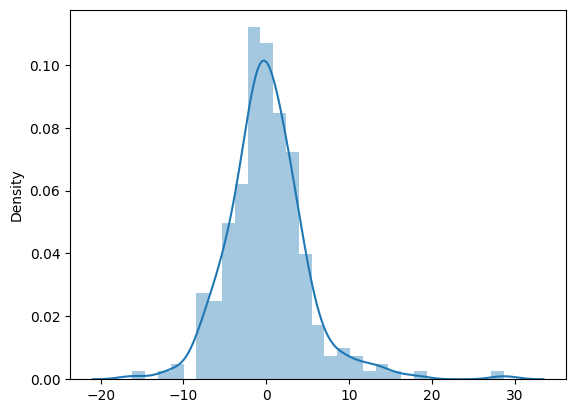

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(residuals))

[2.01651506]


In [ ]:
#let's get a sense of what the variation in the data is.
#standard deviation is 83.
#we can predict within a half of a standard deviation, good. Not great.
print(googletrends['adidas: (United States)'].describe())

count    260.000000
mean      45.038462
std       18.830028
min       17.000000
25%       27.000000
50%       50.000000
75%       58.250000
max      100.000000
Name: adidas: (United States), dtype: float64


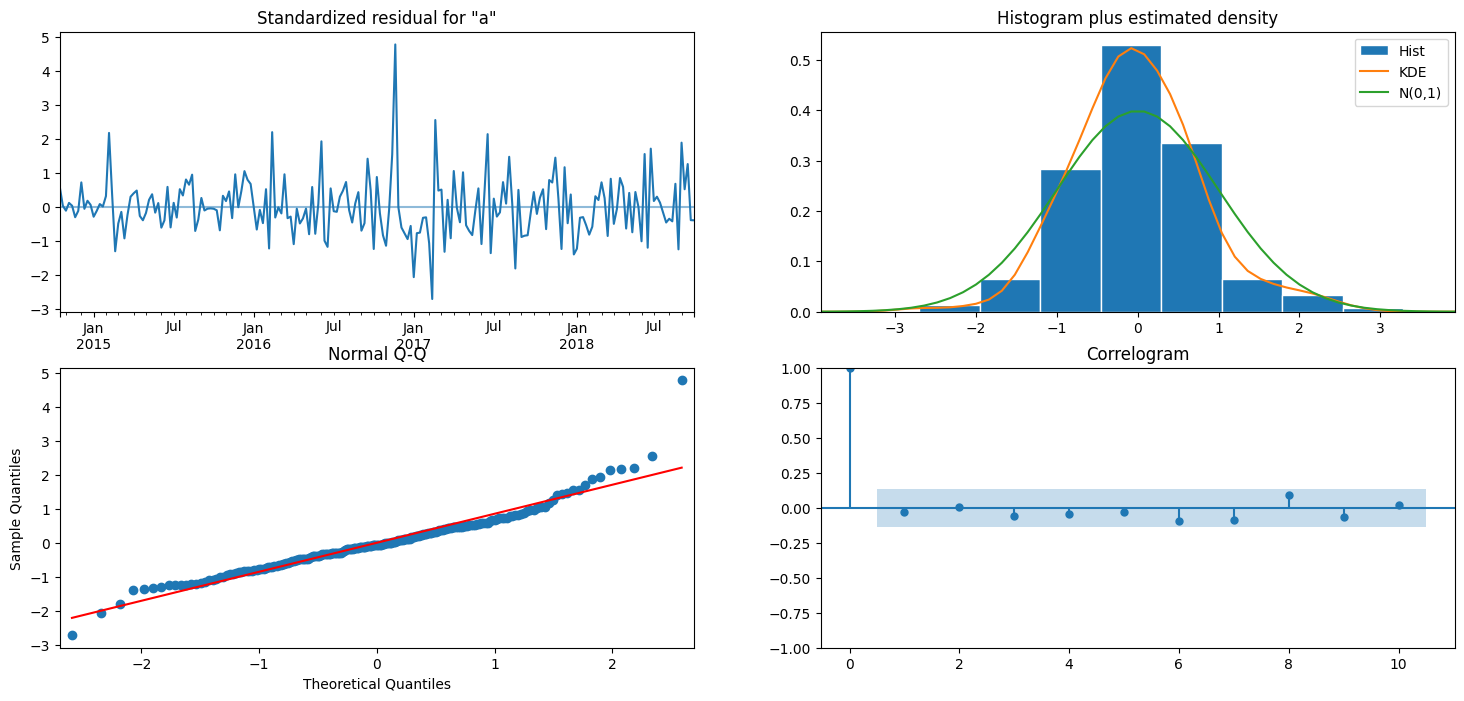

In [ ]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

[Upper Left Plot] - The residuals appear to be fairly uninform across time. 

[Upper Right] - Our residuals look fairly well distributed overall.

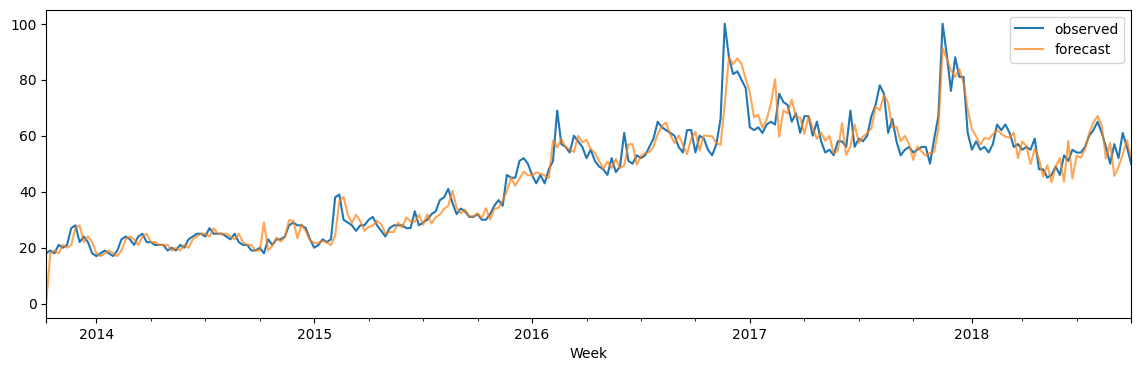

In [ ]:
# Forecasting
pred = model_fit.get_prediction()
pred_ci = model_fit.conf_int()
ax = googletrends['adidas: (United States)'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()


In [ ]:
fcast = model_fit.predict(len(googletrends['adidas: (United States)']),len(googletrends['adidas: (United States)'])+52)

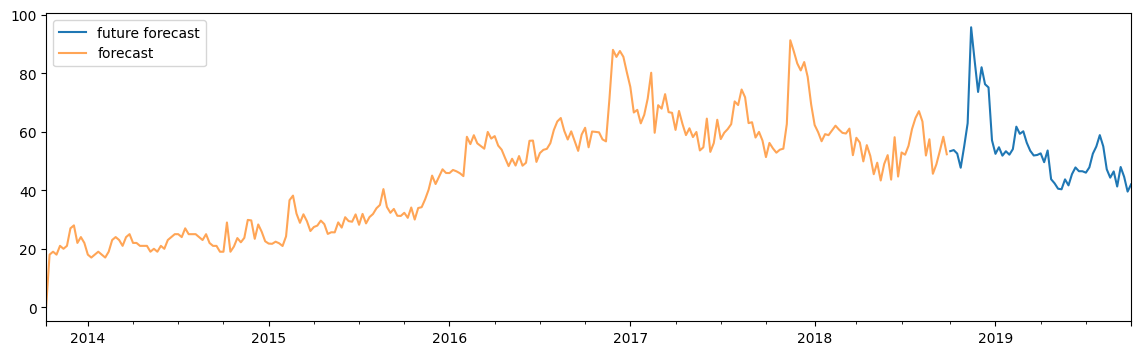

In [ ]:
ax = fcast.plot(label='future forecast')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()


If you want to pull out the predicted values:

In [ ]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2013-10-13    -0.000808
2013-10-20    17.999065
2013-10-27    18.999133
2013-11-03    17.999155
2013-11-10    20.999058
2013-11-17    19.999052
2013-11-24    20.998960
2013-12-01    26.998803
2013-12-08    27.998762
2013-12-15    21.998767
2013-12-22    23.998551
2013-12-29    21.998455
Freq: W-SUN, Name: predicted_mean, dtype: float64

# SARIMAX Modeling - with extra ad spender feature


So the X in a SARIMAX model allows you to model the additional variance that an exogenous variable has on your data. Put another way, you can add a predictor varible to the mix and see if it's predictive!

Does ad spend predict google trendsd interest?


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

Let's load the X varible in.

In [ ]:
adspend = pd.read_csv('%s/adidas.apsend.csv' % DATA_DIR)

In [ ]:
# # Kevin's data loading
adspend = pd.read_csv("/content/adidas.apsend.csv")

In [ ]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Adidas : Sneakers Men,580.4,0.0,580.4,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Adidas : Soccer Apparel & Shoes,74.7,0.0,74.7,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,"WEEK OF OCT 07, 2013 (B)",Adidas CrazyQuick : Sneakers Men,10.5,0.0,10.5,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,"WEEK OF OCT 07, 2013 (B)",ADIDAS FACTORY OUTLET : Family,10.1,0.0,0.0,0.0,0.0,0,0.0,0.0,0,10.1,0.0
4,"WEEK OF OCT 07, 2013 (B)",Adidas Shoe Store : Men & Women,0.7,0.0,0.0,0.0,0.0,0,0.0,0.7,0,0.0,0.0


In [ ]:
adspend.columns

Index(['TIME PERIOD', 'PRODUCT', 'TOTAL DOLS (000)', 'NETWORK TV DOLS (000)',
       'CABLE TV DOLS (000)', 'SPOT TV DOLS (000)', 'MAGAZINES DOLS (000)',
       'SUNDAY MAGS DOLS (000)', 'NATL NEWSP DOLS (000)',
       'NEWSPAPER DOLS (000)', 'NETWORK RADIO DOLS (000)',
       'NAT SPOT RADIO DOLS (000)', 'OUTDOOR DOLS (000)'],
      dtype='object')

In [ ]:
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF ", "")
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "") #\escape character
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "") #\escape character
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])
adspendnoproducts=adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

<ipython-input-59-e5bf7690c187>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "") #\escape character
<ipython-input-59-e5bf7690c187>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "") #\escape character
<ipython-input-59-e5bf7690c187>:5: FutureWarning: The operation <function sum at 0x7f58741dfd00> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  adspendnoproducts=adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)


In [ ]:
adspendnoproducts.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-04', '2013-11-11', '2013-11-18', '2013-11-25',
               '2013-12-02', '2013-12-09',
               ...
               '2018-06-25', '2018-07-02', '2018-07-09', '2018-07-16',
               '2018-07-23', '2018-07-30', '2018-08-20', '2018-08-27',
               '2018-09-17', '2018-10-01'],
              dtype='datetime64[ns]', name='FIXED TIME', length=249, freq=None)

In [ ]:
adspendnoproducts

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL
FIXED TIME,,,,,,,,,,,
2013-10-07,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8
2013-10-14,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3
2013-10-21,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6
2013-10-28,1366.4,715.0,11.5,0.0,0,195.0,4.6,10.8,0.9,0,2304.2
2013-11-04,835.1,0.0,13.5,0.0,0,126.0,8.2,0.0,0.0,0,982.8
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,0.0,0.0,0.7,0.0,0,0.0,0.0,247.5,0.0,0,248.2
2018-08-20,0.0,58.0,0.0,320.5,0,0.0,0.0,0.0,0.0,0,378.5
2018-08-27,0.0,0.0,0.0,0.0,0,0.0,0.0,295.3,0.6,0,295.9


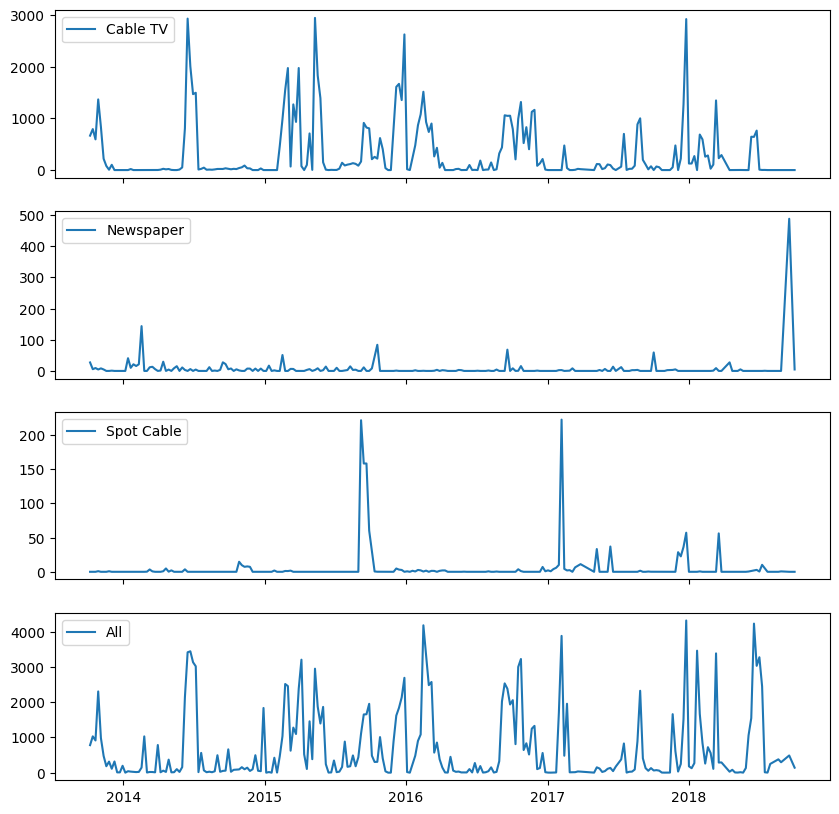

In [ ]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'], label = 'Cable TV')
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'], label = 'Newspaper')
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV'], label = 'Spot Cable') #Spot cable is one of two basic ways to buy advertising on cable television. It allows regional small-business owners to show their TV ads on national cable networks that air in their local markets without having to buy airtime from those networks.
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'], label = 'All')
ax1.legend(loc = 2)
ax2.legend(loc = 2)
ax3.legend(loc = 2)
ax4.legend(loc = 2)

plt.show()

In [ ]:
testdate = pd.to_datetime("2013-10-07")
testdate.weekday() # this is monday

0

Uh-oh. Our dates are off. What is the day of week for our Google Trends data?

In [ ]:
googletrends.head()

,adidas: (United States),trends_diff_1
Week,,
2013-10-13,18,NaN
2013-10-20,19,1.0
2013-10-27,18,-1.0
2013-11-03,21,3.0
2013-11-10,20,-1.0


In [ ]:
adspendnoproducts['FIXED DATE'] = adspendnoproducts.index - pd.DateOffset(1)

In [ ]:
adspendnoproducts['FIXED DATE']

FIXED TIME
2013-10-07   2013-10-06
2013-10-14   2013-10-13
2013-10-21   2013-10-20
2013-10-28   2013-10-27
2013-11-04   2013-11-03
                ...    
2018-07-30   2018-07-29
2018-08-20   2018-08-19
2018-08-27   2018-08-26
2018-09-17   2018-09-16
2018-10-01   2018-09-30
Name: FIXED DATE, Length: 249, dtype: datetime64[ns]

In [ ]:
adspendnoproducts.index = adspendnoproducts['FIXED DATE']
del adspendnoproducts['FIXED DATE']

In [ ]:
adspendnoproducts

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL
FIXED DATE,,,,,,,,,,,
2013-10-06,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8
2013-10-13,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3
2013-10-20,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6
2013-10-27,1366.4,715.0,11.5,0.0,0,195.0,4.6,10.8,0.9,0,2304.2
2013-11-03,835.1,0.0,13.5,0.0,0,126.0,8.2,0.0,0.0,0,982.8
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-29,0.0,0.0,0.7,0.0,0,0.0,0.0,247.5,0.0,0,248.2
2018-08-19,0.0,58.0,0.0,320.5,0,0.0,0.0,0.0,0.0,0,378.5
2018-08-26,0.0,0.0,0.0,0.0,0,0.0,0.0,295.3,0.6,0,295.9


In [ ]:
googletrends['TOTAL ADSPEND'] = adspendnoproducts['TOTAL']

In [ ]:
googletrends

,adidas: (United States),trends_diff_1,TOTAL ADSPEND
Week,,,
2013-10-13,18,NaN,1030.3
2013-10-20,19,1.0,913.6
2013-10-27,18,-1.0,2304.2
2013-11-03,21,3.0,982.8
2013-11-10,20,-1.0,474.5
...,...,...,...
2018-09-02,57,7.0,NaN
2018-09-09,52,-5.0,NaN
2018-09-16,61,9.0,488.1


In [ ]:
googletrends_droplastrow = googletrends[:-1]

In [ ]:
googletrends_droplastrow = googletrends_droplastrow.dropna() #Was not here before-Elise

In [ ]:
model = sm.tsa.statespace.SARIMAX(googletrends_droplastrow['adidas: (United States)'], trend='t', order=(3,1,3), seasonal_order=(1,1,1,52), exog = googletrends_droplastrow['TOTAL ADSPEND'])
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

                                      SARIMAX Results                                       
Dep. Variable:              adidas: (United States)   No. Observations:                  246
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 52)   Log Likelihood                -631.151
Date:                              Fri, 05 May 2023   AIC                           1284.302
Time:                                      17:44:32   BIC                           1320.192
Sample:                                           0   HQIC                          1298.837
                                              - 246                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
drift            -0.0003      0.000     -0.757      0.449      -0.001       0.001
TOTAL ADSP

In [ ]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(residuals))

[2.01651506]


This model shows even better AIC compare to previous one. We may consider use this one since the metrics shows it's the best among all other models.

## Discussion 

How do we choose the parameter for optimal model? 

We used  "order=(3,1,3), seasonal_order=(1,1,1,52)" in the optimal model. While we started by using (5,1,5) for "order" actually (based on ACF, ADF (using 1st difference), and PACF), and iterate with some other numbers. (3,1,3) gave the best result. we continue to use 52 in the second argument to try to capture the yearly trend, and it did improve the performance as well (The reason why we used 52 is that there would always be a peak at the end of the year, we were trying to get that pattern).